# Daq Setup

In [1]:
import pynq

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from Biquad.Biquad_Daq import Biquad_Daq

from Utils.PlotTools import PlottingTools as pt

from Waveforms.Waveform import Waveform
from Waveforms.Gated import Gated
from Waveforms.Filterred import Filterred
from Waveforms.SimFilter import SimFilter

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
daq = Biquad_Daq()

daq.setA(1)
daq.setB(0)
daq.setP(0)
daq.setTheta(np.pi)
daq.setM(8)

Turning on SYNC
Turning off SYNC


# Sim Setup

In [2]:
from Biquad.SimBiquad import SimBiquad

# Test FIR

## Test single zero FIR

In [3]:
def rms(arr):
    square_sum = sum(x ** 2 for x in arr)
    mean_square = square_sum / len(arr)
    return np.sqrt(mean_square)

In [4]:
def update_daq_zero(A, B):
    daq.setA(A)
    daq.setB(B)
    
    daq.set_single_zero_fir()
    
def update_sim_zero(A, B, biquad):
    biquad.setA(A)
    biquad.setB(B)
    
    biquad.single_zero_fir()
    return biquad

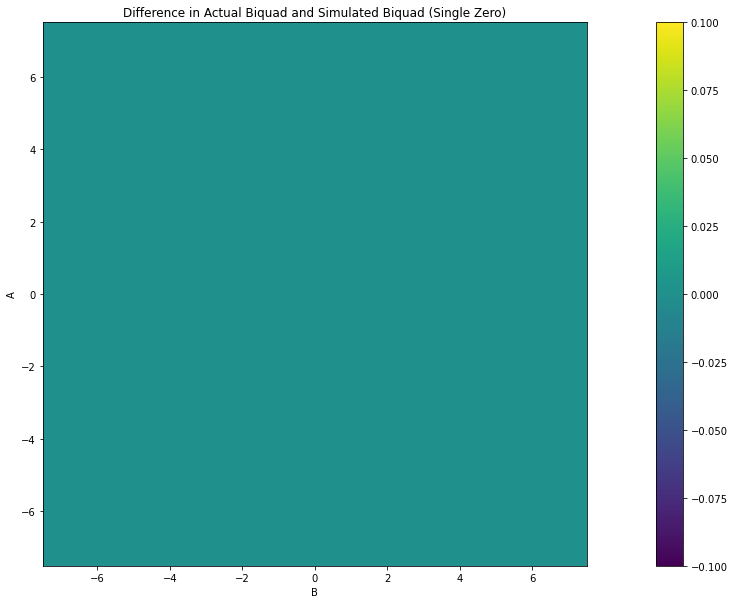

In [5]:
result = []
temp = []
for A in range(-8, 8):
    for B in range(-8,8):
        
        update_daq_zero(A=A, B=B)
    
        daq.JupyterAcquire()

        biquad = SimBiquad(data=daq.waveforms[0].waveform, A=A, B=B, P=0, theta=1, M=8)  
        biquad.IIR()
        temp.append(rms(np.array(daq.waveforms[2].waveform[:512])-biquad.get_decimated()))
    result.append(temp)
    temp = []

plt.figure(figsize=(25, 10))
plt.imshow(result, cmap='viridis', interpolation='nearest', extent=[-7.5,7.5,7.5,-7.5])
plt.colorbar()  # Show a colorbar
plt.title("Difference in Actual Biquad and Simulated Biquad (Single Zero)")
plt.xlabel('B')
plt.ylabel('A')
plt.gca().invert_yaxis()
plt.show()

# if np.mean(result.flatten()) == 0:
#     print("All good innit")
# else:
#     print("Somethings wrong")

## Test f and g

In [6]:
def update_daq_fir1(A, B, P, Theta, M):
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(np.pi*Theta)
    daq.setM(M)
    
    daq.set_single_zero_fir()
    daq.set_f_fir()
    daq.set_g_fir()
    
def update_sim_fir1(A, B, P, Theta, M, biquad):
    biquad.setA(A)
    biquad.setB(B)
    biquad.setP(P)
    biquad.setTheta(np.pi*Theta)
    
    biquad.single_zero_fir()
    biquad.first_constants()
    return biquad

### Test P

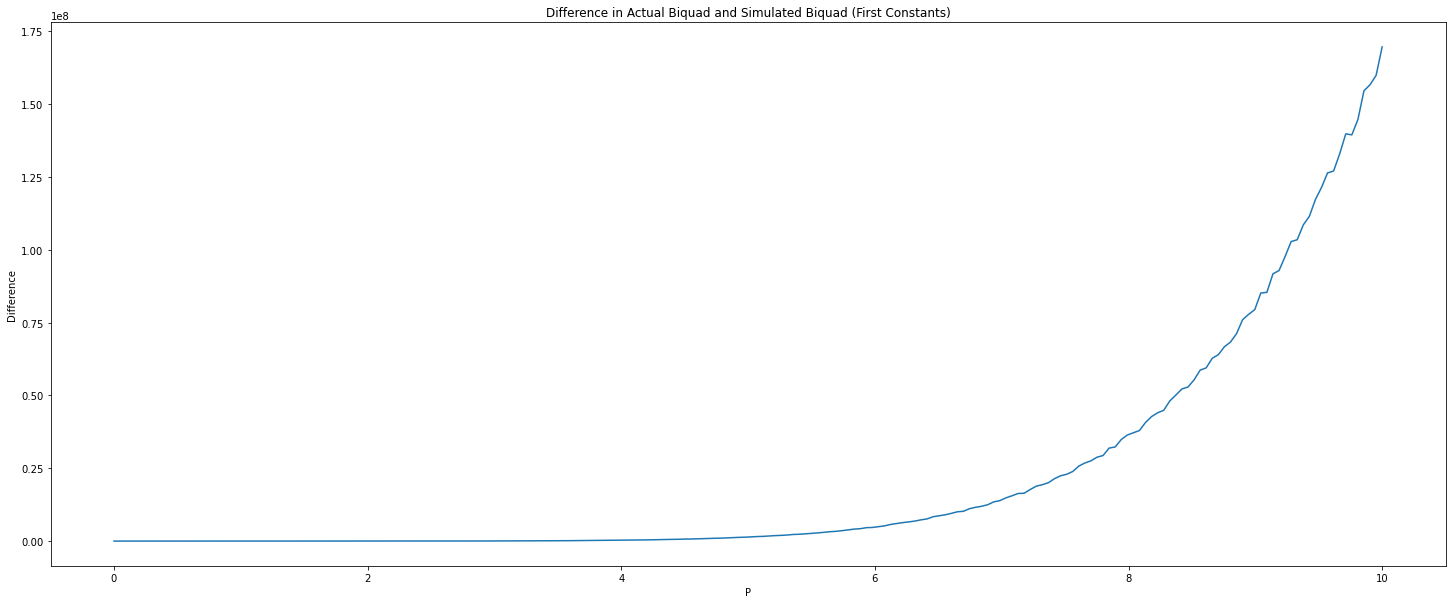

In [7]:
ps = np.linspace(0,10,210)
result = []
for P in ps:
    update_daq_fir1(A=0, B=1, P=P, Theta=1, M=8)

    daq.JupyterAcquire()

    biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=0, B=1, P=P, theta=1, M=8)  
    biquad.single_zero_fir()
    biquad.first_constants()
    
    sim_output = SimFilter(biquad.get_decimated1())
    
    result.append(rms(np.array(daq.waveforms[2].waveform)-sim_output.waveform))
    
plt.figure(figsize=(25, 10))
plt.plot(ps, result)
plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants)")
plt.xlabel('P')
plt.ylabel('Difference')
plt.show()

### Test Theta

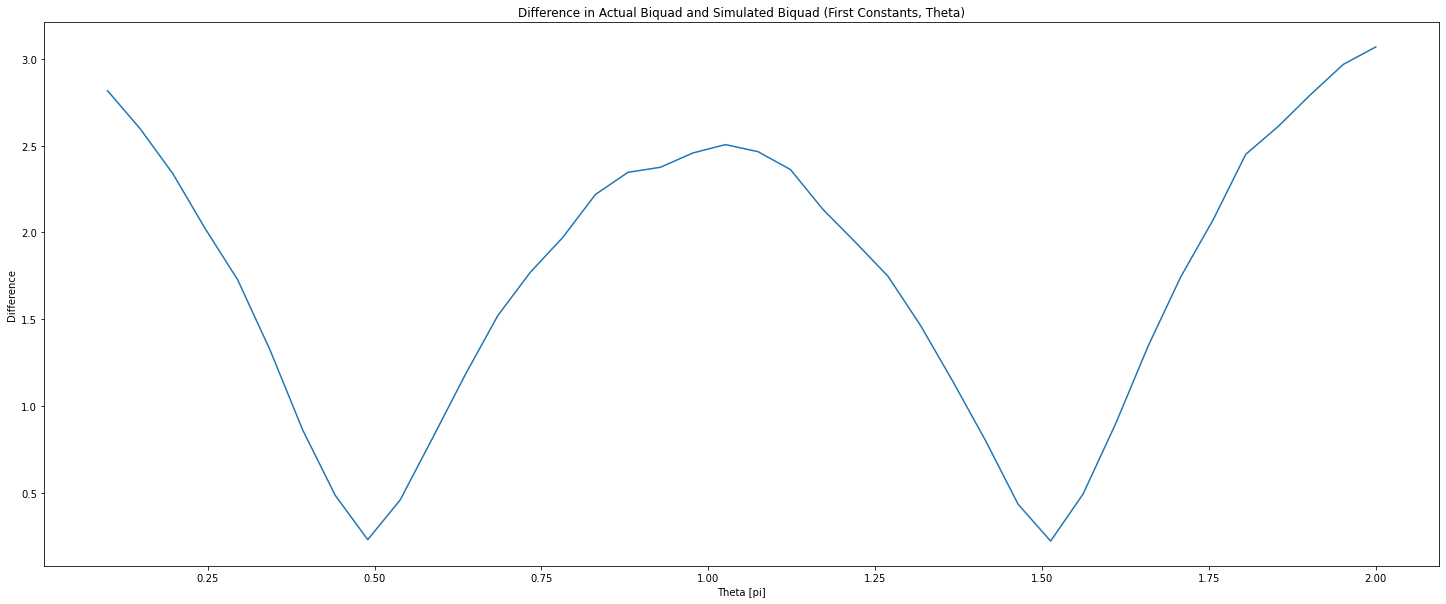

In [13]:
os = np.linspace(0.1,2,40)
result = []
for Theta in os:
    update_daq_fir1(A=0, B=1, P=0.1, Theta=Theta, M=8)

    daq.JupyterAcquire()

    biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=0, B=1, P=0.1, theta=Theta*np.pi, M=8)  
    biquad.single_zero_fir()
    biquad.first_constants()
    
    sim_output = SimFilter(biquad.get_decimated1())
    
    result.append(rms(np.array(daq.waveforms[2].waveform)-sim_output.waveform))
    
plt.figure(figsize=(25, 10))
plt.plot(os, result)
plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants, Theta)")
plt.xlabel('Theta [pi]')
plt.ylabel('Difference')
plt.show()

### Test Both

In [9]:
print(np.linspace(0,1,21))
print(np.linspace(0.1,2,20))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]


(21, 20)


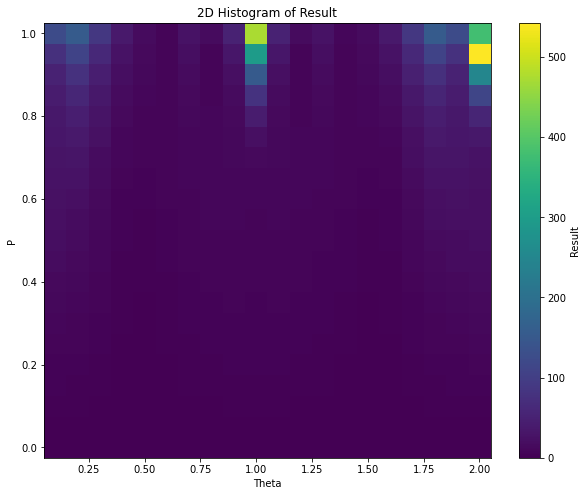

In [10]:
ps = np.linspace(0,1,21)
os = np.linspace(0.1,2,20)

result = []

for P in ps:
    temp = []
    for Theta in os:
        
        update_daq_fir1(A=0, B=1, P=P, Theta=Theta, M=8)
    
        daq.JupyterAcquire()

        biquad = SimBiquad(data=daq.adcBuffer[0] >> 4, A=0, B=1, P=P, theta=np.pi*Theta, M=8)
        biquad.single_zero_fir()
        biquad.first_constants()

        sim_output = SimFilter(biquad.get_decimated1())

        temp.append(rms(np.array(daq.waveforms[2].waveform-sim_output.waveform)))

    result.append(temp)
    
result = np.array(result)
print(np.shape(result))


plt.figure(figsize=(10, 8))
plt.imshow(result, extent=[os.min()-0.05, os.max()+0.05, ps.min()-0.025, ps.max()+0.025], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Result')
plt.xlabel('Theta')
plt.ylabel('P')
plt.title('2D Histogram of Result')
plt.show()

# plt.figure(figsize=(25, 10))
# plt.imshow(result, cmap='viridis', interpolation='nearest', extent=[0, 1, 0.1, 2])
# plt.colorbar()  # Show a colorbar
# plt.title("Difference in Actual Biquad and Simulated Biquad (First Constants, both)")
# plt.xlabel('P')
# plt.ylabel('Theta')
# plt.gca().invert_yaxis()
# plt.show()

In [11]:
# biquad = SimBiquad(data=daq.waveforms[0].waveform, A=0, B=1, P=0, theta=1, M=8)
# biquad.IIR()
# sim_output = SimFilter(biquad.get_decimated2())

# plt.figure(figsize=(25, 15))
# plt.plot(biquad.get_decimated2()[1::2], label='G')
# plt.plot(biquad.get_decimated2()[0::2], label='F')

# major_ticks_x = np.arange(0, 65, 8)  # 0 to 32 with step 8
# plt.xticks(major_ticks_x)

# plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')

# plt.legend()
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.title('Biquad Filter Output with Custom Grid Intervals')

# plt.show()

In [12]:
t = 7
M = 8

b = t//M
n = t%M

print(M*b+n)
print(b)
print(n)

7
0
7
